## Load the model from Hugging Face Hub:

In [1]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/cxrmate-tf'

dataset_dir = '/scratch/pawsey0864/anicolson/datasets'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True).to(device)
encoder_decoder.eval()
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name)
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name)

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)

/software/projects/pawsey0864/anicolson/environments/multimodal_23/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/a

trainable params: 147456 || all params: 80916528 || trainable%: 0.18223223814051934


/software/projects/pawsey0864/anicolson/environments/multimodal_23/lib/python3.10/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


## The images for the first study of each patient:

In [2]:
# Images from the first study of Patient 1:
image_1 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s59968351/9eef23a6-9ec5cac1-17521310-3e505395-c63ed35d.jpg'))
image_1 = image_1.convert('RGB')

image_2 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s59968351/ae032259-83a5d5ec-8bce36ad-8313ec75-f32fb108.jpg'))
image_2 = image_2.convert('RGB')

# Images from the first study of Patient 2:
image_3 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s59968351/9eef23a6-9ec5cac1-17521310-3e505395-c63ed35d.jpg'))
image_3 = image_3.convert('RGB')

image_4 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s59968351/ae032259-83a5d5ec-8bce36ad-8313ec75-f32fb108.jpg'))
image_4 = image_4.convert('RGB')

image_1 = test_transforms(image_1)
image_2 = test_transforms(image_2)
image_3 = test_transforms(image_3)
image_4 = test_transforms(image_4)

study_a = torch.stack([image_1, image_2], dim=0)
study_b = torch.stack([image_3, image_4], dim=0)

images = torch.nn.utils.rnn.pad_sequence([study_a, study_b], batch_first=True, padding_value=0.0)
images.shape

torch.Size([2, 2, 3, 384, 384])

### Images from all of the studies:

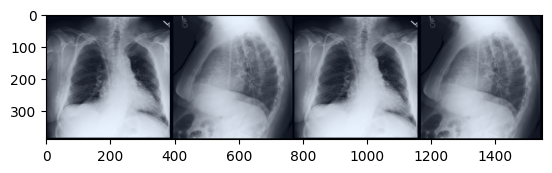

In [3]:
display_images = torch.stack([image_1, image_2, image_3, image_4], dim=0)
plt.imshow(make_grid(display_images, normalize=True).permute(1, 2, 0))

In [4]:
# No previous findings and impression sections available:
previous_findings = [None, None]
previous_impression = [None, None]

# Tokenize prompt:
prompt = encoder_decoder.tokenize_prompt(
    previous_findings, 
    previous_impression, 
    tokenizer, 
    256, 
    add_bos_token_id=True,
)
prompt

{'input_ids': tensor([[ 8, 10,  9, 11,  1],
         [ 8, 10,  9, 11,  1]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]], device='cuda:0')}

## Generate the reports:

In [5]:
outputs = encoder_decoder.generate(
    pixel_values=images.to(device),
    decoder_input_ids=prompt['input_ids'],
    special_token_ids=[
        tokenizer.additional_special_tokens_ids[
            tokenizer.additional_special_tokens.index('[PMT-SEP]')
        ],
        tokenizer.bos_token_id,
        tokenizer.sep_token_id,
    ],  
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    mask_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256 + prompt['input_ids'].shape[1],
    num_beams=4,
)
outputs.sequences

tensor([[   8,   10,    9,   11,    1,  846,  148,  369,  546,  132,  115,  250,
           23, 2675, 3991,  182,   22,  580,  732,  816,  535,  120,  269,  172,
         1085,  443,  125,  115,  182,  878,   23,  213,  150,  558,  626, 1074,
         1841,  115,  342,   23,  213,  120,  163, 1660,  284, 3224,  171,   23,
          139,  449,  278,  120,  437,  237,  526,   23, 2310, 1233,  456,  282,
          115,  941, 1394,   23,  198,  271,  542,  578,  120, 1186,   23,    3,
         2159,  626, 1074, 1841,  115,  342,  515,  763,  233,  269,  125,  115,
          897,  132,  626,  280, 1025, 2416,  785,  120,  716, 1203,   23,    2],
        [   8,   10,    9,   11,    1,  846,  148,  369,  546,  132,  115,  250,
           23, 2675, 3991,  182,   22,  580,  732,  816,  535,  120,  269,  172,
         1085,  443,  125,  115,  182,  878,   23,  213,  150,  558,  626, 1074,
         1841,  115,  342,   23,  213,  120,  163, 1660,  284, 3224,  171,   23,
          139,  449,  278, 

## Decode using the tokenizer:

In [6]:
# Findings and impression sections (exclude previous impression section):
_, findings, impression = encoder_decoder.split_and_decode_sections(
    outputs.sequences,
    [tokenizer.bos_token_id, tokenizer.sep_token_id, tokenizer.eos_token_id],
    tokenizer
)

for i, j in zip(findings, impression):
    print(f'Findings: {i}\nImpression: {j}\n')

Findings: Frontal and lateral views of the chest. Dual lumen right-sided central venous catheter is seen with distal tip in the right atrium. There are increased interstitial markings throughout the lungs. There is no confluent consolidation nor effusion. The cardiomediastinal silhouette is within normal limits. Atherosclerotic calcifications noted at the aortic arch. No acute osseous abnormality is detected.
Impression: Increased interstitial markings throughout the lungs which can be seen in the setting of interstitial edema although atypical infection is also possible.

Findings: Frontal and lateral views of the chest. Dual lumen right-sided central venous catheter is seen with distal tip in the right atrium. There are increased interstitial markings throughout the lungs. There is no confluent consolidation nor effusion. The cardiomediastinal silhouette is within normal limits. Atherosclerotic calcifications noted at the aortic arch. No acute osseous abnormality is detected.
Impress

## The images for the second study of each patient:

In [7]:
# Images from the second study of Patient 1:
image_1 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s54028344/4a5283d6-157b6054-3840ea3d-d27e7ba1-d6689022.jpg'))
image_1 = image_1.convert('RGB')

image_2 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s54028344/7794e4cb-719a0b85-18532575-0b5ea119-8eb26b6a.jpg'))
image_2 = image_2.convert('RGB')

# Images form the second study from Patient 2:
image_3 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p15/p15131736/s57531802/308bf948-d05f2a1d-2c32a818-2df09584-d17283f6.jpg'))
image_3 = image_3.convert('RGB')

image_1 = test_transforms(image_1)
image_2 = test_transforms(image_2)
image_3 = test_transforms(image_3)

study_a = torch.stack([image_1, image_2], dim=0)
study_b = torch.stack([image_3], dim=0)

images = torch.nn.utils.rnn.pad_sequence([study_a, study_b], batch_first=True, padding_value=0.0)
images.shape

torch.Size([2, 2, 3, 384, 384])

### Images from all of the studies:

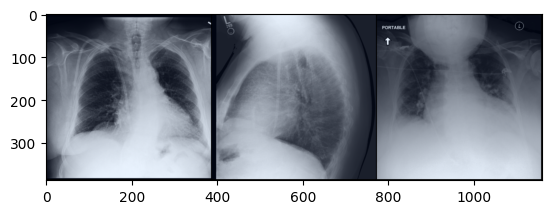

In [8]:
display_images = torch.stack([image_1, image_2, image_3], dim=0)
plt.imshow(make_grid(display_images, normalize=True).permute(1, 2, 0))

## Tokenize the findings and impression sections from the previous studies:

In [9]:
# Previously generated findings and impression sections:
previous_findings = findings
previous_impression = impression

# Tokenize prompt:
prompt = encoder_decoder.tokenize_prompt(
    previous_findings, 
    previous_impression, 
    tokenizer, 
    256, 
    add_bos_token_id=True,
)
prompt

{'input_ids': tensor([[   8,  846,  148,  369,  546,  132,  115,  250,   23, 2675, 3991,  182,
            22,  580,  732,  816,  535,  120,  269,  172, 1085,  443,  125,  115,
           182,  878,   23,  213,  150,  558,  626, 1074, 1841,  115,  342,   23,
           213,  120,  163, 1660,  284, 3224,  171,   23,  139,  449,  278,  120,
           437,  237,  526,   23, 2310, 1233,  456,  282,  115,  941, 1394,   23,
           198,  271,  542,  578,  120, 1186,   23,    9, 2159,  626, 1074, 1841,
           115,  342,  515,  763,  233,  269,  125,  115,  897,  132,  626,  280,
          1025, 2416,  785,  120,  716, 1203,   23,    1],
         [   8,  846,  148,  369,  546,  132,  115,  250,   23, 2675, 3991,  182,
            22,  580,  732,  816,  535,  120,  269,  172, 1085,  443,  125,  115,
           182,  878,   23,  213,  150,  558,  626, 1074, 1841,  115,  342,   23,
           213,  120,  163, 1660,  284, 3224,  171,   23,  139,  449,  278,  120,
           437,  237,  526

## Generate the reports:

In [10]:
outputs = encoder_decoder.generate(
    pixel_values=images.to(device),
    decoder_input_ids=prompt['input_ids'],
    special_token_ids=[
        tokenizer.additional_special_tokens_ids[
            tokenizer.additional_special_tokens.index('[PMT-SEP]')
        ],
        tokenizer.bos_token_id,
        tokenizer.sep_token_id,
    ],  
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    mask_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256 + prompt['input_ids'].shape[1],
    num_beams=4,
)
outputs.sequences

tensor([[   8,  846,  148,  369,  546,  132,  115,  250,   23, 2675, 3991,  182,
           22,  580,  732,  816,  535,  120,  269,  172, 1085,  443,  125,  115,
          182,  878,   23,  213,  150,  558,  626, 1074, 1841,  115,  342,   23,
          213,  120,  163, 1660,  284, 3224,  171,   23,  139,  449,  278,  120,
          437,  237,  526,   23, 2310, 1233,  456,  282,  115,  941, 1394,   23,
          198,  271,  542,  578,  120, 1186,   23,    9, 2159,  626, 1074, 1841,
          115,  342,  515,  763,  233,  269,  125,  115,  897,  132,  626,  280,
         1025, 2416,  785,  120,  716, 1203,   23,    1, 1097,   22,  580, 1695,
           22, 3509,  732,  816,  535,  120,  269,  172, 1085,  443,  125,  115,
          182,  878,   23, 1528,  626, 1074,  150,  269, 1841,  115,  342,   21,
          534,  602,  378,   23,  213,  120,  163, 1660,  284,  214,  171,   23,
          139,  449,  278,  120,  402,   23,  198,  271,  542,  666,  619,   23,
            3, 1038,  626,  

## Decode using the tokenizer:

In [11]:
# Findings and impression sections (exclude previous impression section):
_, findings, impression = encoder_decoder.split_and_decode_sections(
    outputs.sequences,
    [tokenizer.bos_token_id, tokenizer.sep_token_id, tokenizer.eos_token_id],
    tokenizer
)
for i, j in zip(findings, impression):
    print(f'Findings: {i}\nImpression: {j}\n')

Findings: Right-sided dual-lumen central venous catheter is seen with distal tip in the right atrium. Increased interstitial markings are seen throughout the lungs, new since prior. There is no confluent consolidation or effusion. The cardiomediastinal silhouette is stable. No acute osseous abnormalities identified.
Impression: Mild interstitial edema. No confluent consolidation.

Findings: The lung volumes are low which causes crowding of the bronchovascular structures. There is mild pulmonary vascular congestion. The heart size is moderately enlarged. The mediastinal and hilar contours are normal. There is no large pleural effusion or pneumothorax. There is no focal consolidation concerning for pneumonia.
Impression: Mild pulmonary vascular congestion.

